# GAN for EIS data simulation 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.functional as F
from torch import nn

In [2]:
#It’s a good practice to set up a random generator seed so that the experiment can be replicated identically on any machine. 
#To do that in PyTorch:
torch.manual_seed(123)

In [3]:
DATA_PATH = './data/'
#sig_i_10 = pd.read_csv(DATA_PATH+'batt2_meas3_sig_i_10.csv')
sig_v_10 = pd.read_csv(DATA_PATH+'batt2_meas3_sig_v_10.csv')

In [4]:
torch.tensor(sig_v_10.values)

tensor([[0.0121],
        [0.0166],
        [0.0172],
        ...,
        [0.0215],
        [0.0177],
        [0.0161]], dtype=torch.float64)

In [5]:
train_data_length = 10000
# initialize train_data, a tensor with dimensions of <train_data_length> rows and 2 columns, all containing zeros. 
# Note: A tensor is a multidimensional array similar to a NumPy array.
train_data = torch.zeros((train_data_length, 2))

#for i  in range(0,train_data_length):
#  f_index = i % 14
#  # the first column of train_data store the frequency values
#  train_data[i, 0] = frequency_list[f_index]

train_data[:, 0] = torch.tensor(range(0, train_data_length))

# calculate the second column of the tensor as the sine of the first column.
train_data[:, 1] = torch.from_numpy(sig_v_10.values[0:train_data_length].transpose())


# init tensor of labels, which are required by PyTorch’s data loader. 
# Since GANs make use of unsupervised learning techniques, the labels can be anything.
train_labels = torch.zeros(train_data_length)

# create train_set as a list of tuples, with each row of train_data and train_labels represented in each tuple 
# this is the format expected by PyTorch’s data loader.
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

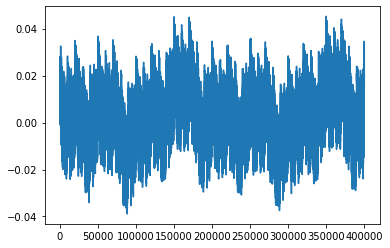

In [6]:
plt.plot(sig_v_10)

In [7]:
# This discriminator is an MLP neural network 
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            #The input is two-dimensional, and the first hidden layer is composed 
            # of 256 neurons with ReLU activation.
            nn.Linear(2, 256),
            nn.ReLU(),
            # use dropout after hidden layer to avoid overfitting.
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            # The output is composed of a single neuron with sigmoidal activation
            # to represent a probability.
            nn.Sigmoid(),
        )

     # .forward() to describe how the output of the model is calculated
    def forward(self, x):
        output = self.model(x)
        return output

# instantiate a Discriminator object
discriminator = Discriminator()

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

In [9]:
# create a PyTorch data loader called train_loader.
# Data Loader will shuffle the data from train_set and return batches of <batch_size> samples 
# to be used to train the neural networks.

batch_size = 1024
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, drop_last=True, shuffle=True
)

In [10]:
lr = 0.001
num_epochs = 300

# The binary cross-entropy function is a suitable loss function for training the discriminator 
# because it considers a binary classification task. 
# It’s also suitable for training the generator since it feeds its output to the discriminator,
# which provides a binary observable output.
loss_function = nn.BCELoss()

In [11]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [12]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 7.817830562591553
Epoch: 0 Loss G.: 0.6617491841316223
Epoch: 0 Loss D.: 0.6341876983642578
Epoch: 0 Loss G.: 0.6581073999404907
Epoch: 0 Loss D.: 0.36615896224975586
Epoch: 0 Loss G.: 0.6616637706756592
Epoch: 0 Loss D.: 0.3637688457965851
Epoch: 0 Loss G.: 0.6654543876647949
Epoch: 0 Loss D.: 0.36226457357406616
Epoch: 0 Loss G.: 0.6716423630714417
Epoch: 0 Loss D.: 0.358889639377594
Epoch: 0 Loss G.: 0.6790692806243896
Epoch: 0 Loss D.: 0.35476455092430115
Epoch: 0 Loss G.: 0.6877325773239136
Epoch: 0 Loss D.: 0.351041704416275
Epoch: 0 Loss G.: 0.6959391236305237
Epoch: 0 Loss D.: 0.34609338641166687
Epoch: 0 Loss G.: 0.7039754390716553
Epoch: 10 Loss D.: 0.07588188350200653
Epoch: 10 Loss G.: 3.6183464527130127
Epoch: 10 Loss D.: 0.03298146277666092
Epoch: 10 Loss G.: 3.5947952270507812
Epoch: 10 Loss D.: 0.032294128090143204
Epoch: 10 Loss G.: 3.5663323402404785
Epoch: 10 Loss D.: 0.033732958137989044
Epoch: 10 Loss G.: 3.5786056518554688
Epoch: 10 Loss D.: 0.08

In [13]:
latent_space_samples = torch.randn(1000, 2)
generated_samples = generator(latent_space_samples)

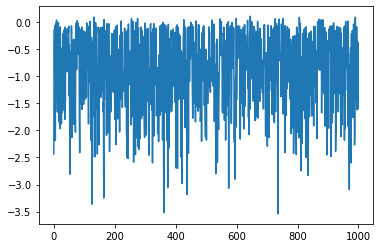

In [14]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 1])

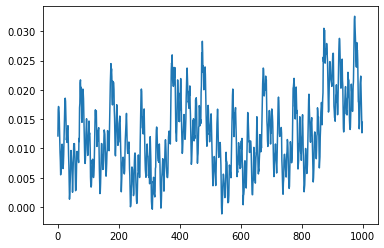

In [15]:
plt.plot(sig_v_10[0:1000])